# Span detection RU only implementation

1. Import dependencies

In [1]:
import random
import time

import numpy as np
import torch
import os

from transformers import (
    AutoTokenizer,
    DataCollatorForTokenClassification,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    pipeline,
)

from src.util.torch_device import resolve_torch_device
from src.data.span_detection_ds import ManipulationDetectionDataset
from src.visualization.plot import plot_loss, plot_model_progress, plot_eval_loss
from src.definitions import (
    MODELS_FOLDER,
    RAW_DATA_FOLDER,
    REPORTS_FOLDER,
    PROCESSED_DATA_FOLDER,
)
from src.visualization.ner import MarkdownVisualizer, VisualizationMode
from src.visualization.reporting import EvaluatingReport
from src.model.span_detection_metrics import compute_metrics

2. Prepare Env

In [ ]:
random_seed = 42

random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

device = resolve_torch_device()

model_checkpoint = "FrinzTheCoder/bert-base-multilingual-cased-rus"

epoch_time = int(time.time())

os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"

3. Load dataset

In [3]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

dataset_blueprint = ManipulationDetectionDataset(
    tokenizer=tokenizer,
    raw_path=RAW_DATA_FOLDER / "span-detection.parquet",
    processed_path=PROCESSED_DATA_FOLDER / "span-detection-ru" / model_checkpoint,
    seed=random_seed,
    lang='ru'
)

dataset = dataset_blueprint.read()

Map:   0%|          | 0/3439 [00:00<?, ? examples/s]

Map:   0%|          | 0/383 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3439 [00:00<?, ? examples/s]

Filter:   0%|          | 0/383 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1511 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/164 [00:00<?, ? examples/s]

3. Prepare model

In [4]:
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(dataset_blueprint.label2id),
    id2label=dataset_blueprint.id2label,
    label2id=dataset_blueprint.label2id,
    classifier_dropout=0.1,
    ignore_mismatched_sizes=True,
).to(device)

data_collator = DataCollatorForTokenClassification(tokenizer)

training_args = TrainingArguments(
    output_dir=MODELS_FOLDER / "manipulation-span-detection-ru-checkpoint",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    seed=random_seed,
    logging_steps=100,
    auto_find_batch_size=True,
    torch_empty_cache_steps=1000,
    metric_for_best_model="f1",
    greater_is_better=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics(dataset_blueprint),
)

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at ysapolovych/xlm-roberta-large-uanews and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


4. Train model

In [5]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.678254,0.000000,0.000000,0.000000,0.632948
2,0.660000,0.677597,0.000000,0.000000,0.000000,0.633032
3,0.641400,0.653518,0.020408,0.003257,0.005618,0.627206
4,0.621300,0.662982,0.041667,0.003257,0.006042,0.634805
5,0.622900,0.676740,0.043478,0.003257,0.006061,0.635650


/Users/alexandermelashchenko/Workspace/unlp-2025-manipulation-detector/.venv/lib/python3.11/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=475, training_loss=0.6325020398591694, metrics={'train_runtime': 1935.4748, 'train_samples_per_second': 3.903, 'train_steps_per_second': 0.245, 'total_flos': 5884162344344772.0, 'train_loss': 0.6325020398591694, 'epoch': 5.0})

In [6]:
evaluation_feedback = trainer.evaluate()

In [7]:
report_file = REPORTS_FOLDER / "span-detection-ru" / "train-report.csv"

report = EvaluatingReport(report_file)

report.write_to_report(evaluation_feedback, epoch_time)

full_report = report.read_report()

full_report.tail(1)

,timestamp,eval_loss,eval_precision,eval_recall,eval_f1,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
4,1739984062,0.67674,0.043478,0.003257,0.006061,0.63565,7.9906,20.524,2.628,5.0


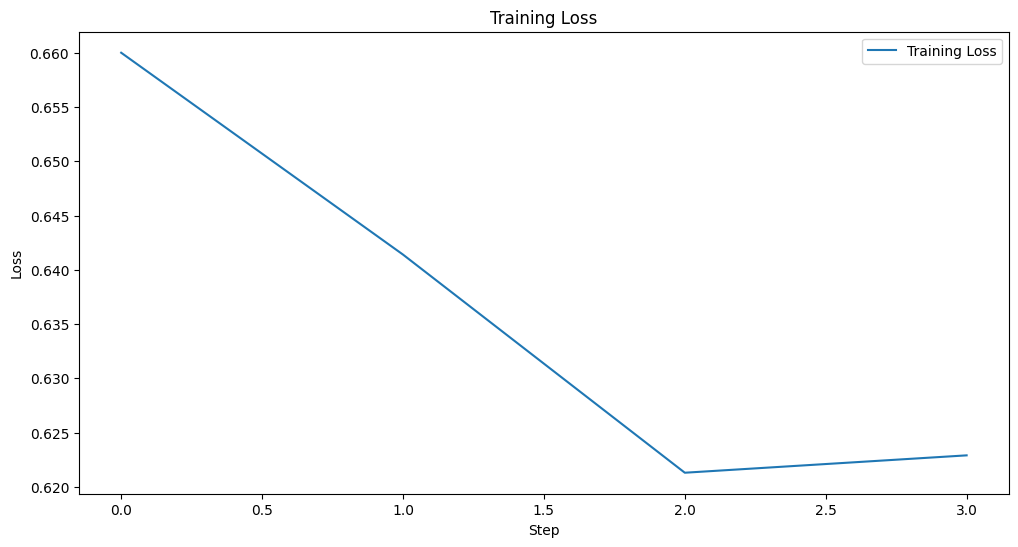

In [8]:
plot_loss(trainer)

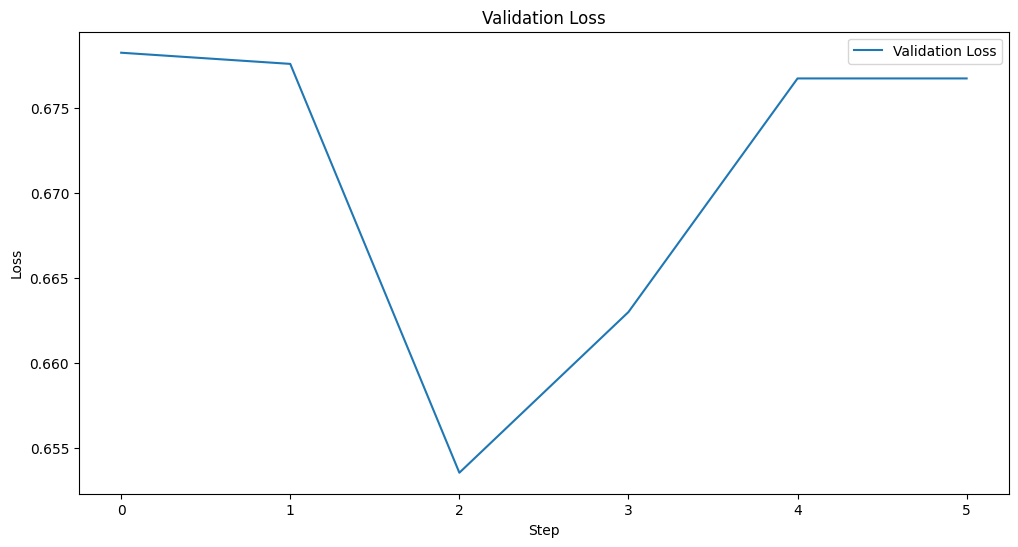

In [9]:
plot_eval_loss(trainer)

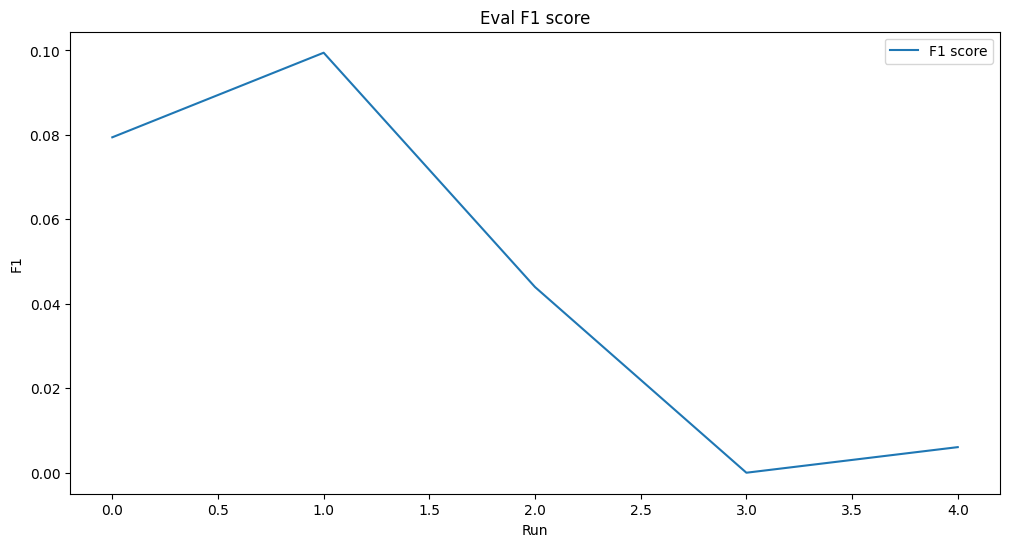

In [10]:
plot_model_progress(full_report)

5. Save weights

In [11]:
trainer.save_model(MODELS_FOLDER / "manipulation-span-detection-ru-model")
tokenizer.save_pretrained(MODELS_FOLDER / "manipulation-span-detection-ru-model")

('/Users/alexandermelashchenko/Workspace/unlp-2025-manipulation-detector/models/manipulation-span-detection-ru-model/tokenizer_config.json',
 '/Users/alexandermelashchenko/Workspace/unlp-2025-manipulation-detector/models/manipulation-span-detection-ru-model/special_tokens_map.json',
 '/Users/alexandermelashchenko/Workspace/unlp-2025-manipulation-detector/models/manipulation-span-detection-ru-model/unigram.json',
 '/Users/alexandermelashchenko/Workspace/unlp-2025-manipulation-detector/models/manipulation-span-detection-ru-model/added_tokens.json',
 '/Users/alexandermelashchenko/Workspace/unlp-2025-manipulation-detector/models/manipulation-span-detection-ru-model/tokenizer.json')

6. Test

In [12]:
model = AutoModelForTokenClassification.from_pretrained(
    MODELS_FOLDER / "manipulation-span-detection-ru-model"
)
tokenizer = AutoTokenizer.from_pretrained(
    MODELS_FOLDER / "manipulation-span-detection-ru-model"
)

In [13]:
test_pipeline = pipeline("ner", model=model, tokenizer=tokenizer)

test_result = test_pipeline(dataset["test"]["content"])

Device set to use mps:0


In [ ]:

visualizer = MarkdownVisualizer(
    tokenizer=tokenizer,
    path=REPORTS_FOLDER
    / "span-detection-ru"
    / "test-visualization"
    / f"test-{epoch_time}.md",
    visualization_mode=VisualizationMode.BERT,
)

visualizer.visualize_as_markdown_and_save(dataset["test"], test_result)